# Funzioni

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)


def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)

  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  print('Confusion matrix:\n', metrics.confusion_matrix(y_test, y_pred))
  return y_test, y_pred

In [ ]:
def balanced_subsample(X, y, subsample_size=1.0):

    classes = y.unique()
    min_elems = y.value_counts().min()

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems * subsample_size)

    Xb = pd.DataFrame()
    yb = pd.Series()

    for c in classes:
      X_ = X[y == c]
      if X_.shape[0] > use_elems:
        X_ = X_.sample(use_elems)

      yc = np.empty(use_elems)
      yc.fill(c)
      y_ = pd.Series(yc)

      Xb = pd.concat([Xb, X_])
      yb = pd.concat([yb, y_])

    return Xb, yb

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(dataset, columns, drop=None):

  categories = []
  ret_columns = []

  if isinstance(columns, str):
    columns = [columns]
  if (drop is not None) and (isinstance(drop, str)):
    drop = [drop]

  for i in range(0, len(columns)):
    ctg = dataset.loc[:, columns[i]].unique().tolist()
    categories.append(ctg)

    ctg_ = ctg.copy();
    if drop is not None:
      ctg_.remove(drop[i])
    ret_columns += ctg_

  encoder = OneHotEncoder(categories=categories, drop=drop).fit(dataset[columns])
  ds = pd.DataFrame(encoder.transform(dataset[columns]).toarray(), columns=ret_columns)

  return ds


def add_dummies(dataset, columns, drop_cat=None, drop_col=True):
  dummies = one_hot_encode(dataset, columns, drop_cat)
  if drop_col:
    dataset.drop(columns=columns, inplace=True)
  dataset = pd.concat([dataset, dummies], axis=1)
  return dataset

In [ ]:
def xtab(dataset, index_col, columns_col, normalize_on_idx=False):
  xtab = pd.crosstab(dataset[index_col], dataset[columns_col])
  if normalize_on_idx:
    for i in xtab.index:
      xtab.loc[i] = xtab.loc[i] / len(dataset[dataset[index_col] == i])
    _ = sns.heatmap(xtab, vmin=0, vmax=1)
  else:
    _ = sns.heatmap(xtab)
  print(xtab)
  return xtab

# Parte 1: Analisi

1. Caricare il dataset e denominarlo con una variabile chiamata “dataset”

In [ ]:
dataset = pd.read_csv('bdastudents.csv', sep=';')
dataset.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,1,A,4,4,at_home,teacher,course,mother,2,2,0,1,0,0,1,1,0,0,4,3,4,1,1,3,6,0,0,0
1,GP,F,17,U,1,T,1,1,at_home,other,course,father,1,2,0,0,1,0,0,1,1,0,5,3,3,1,1,3,4,0,0,0
2,GP,F,15,U,0,T,1,1,at_home,other,other,mother,1,2,3,1,0,1,1,1,1,0,4,3,2,2,3,3,10,1,1,1
3,GP,F,15,U,1,T,4,2,health,services,home,mother,1,3,0,0,1,1,1,1,1,1,3,2,2,1,1,5,2,2,1,2
4,GP,F,16,U,1,T,3,3,other,other,home,father,1,2,0,0,1,1,1,1,0,0,4,3,2,1,2,5,4,0,1,1


2. Quante sono le istanze contenute nel dataset? Il dataset è bilanciato rispetto alle scuole e ai generi degli studenti analizzati?

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   int64 
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   int64 
 16  famsup      1044 non-null   int64 
 17  paid        1044 non-null   int64 
 18  nursery     1044 non-null   int64 
 19  higher      1044 non-null   int64 
 20  internet

In [ ]:
dataset.school.value_counts()
"""
Non è bilanciato rispetto alla scuola
"""

'\nNon è bilanciato rispetto alla scuola\n'

In [ ]:
dataset.sex.value_counts()
"""
Posso considerarlo bilanciato rispetto al sesso, anche se non rispetta le
proporzioni naturali (50:50)
"""

'\nPosso considerarlo bilanciato rispetto al sesso, anche se non rispetta le\nproporzioni naturali (50:50)\n'

3. Creare un nuovo attributo “GRate” che misuri per ogni studente la differenza tra la valutazione ricevuta nel primo e nel secondo periodo. Realizzare un grafico che rappresenti per ogni età questa differenza.

In [ ]:
dataset['GRate'] = dataset.G2 - dataset.G1

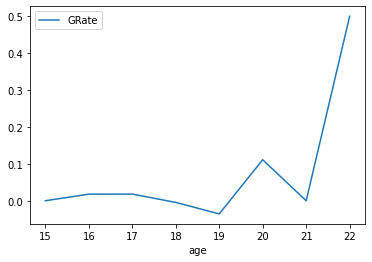

In [ ]:
dataset[['GRate', 'age']].groupby(by='age').mean().plot()

GRate        -1         0         1
age                                
15     0.056701  0.886598  0.056701
16     0.035587  0.911032  0.053381
17     0.061372  0.859206  0.079422
18     0.072072  0.860360  0.067568
19     0.089286  0.857143  0.053571
20     0.111111  0.666667  0.222222
21     0.000000  1.000000  0.000000
22     0.000000  0.500000  0.500000


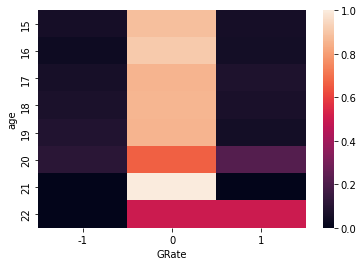

In [ ]:
_ = xtab(dataset, 'age', 'GRate', normalize_on_idx=True)

4. Sono mediamente più bravi (attributo G3) i ragazzi o le ragazze? Esistono delle variazioni rilevanti nelle due scuole considerate?

G3          0         1         2
sex                              
F    0.079526  0.717428  0.203046
M    0.075055  0.739514  0.185430


'La distribuzione degli esiti è pressocchè uguale tra maschi e femmine'

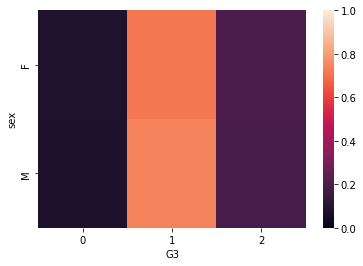

In [ ]:
xtab(dataset, 'sex', 'G3', normalize_on_idx=True)
"""La distribuzione degli esiti è pressocchè uguale tra maschi e femmine"""

G3             0         1         2
school                              
GP      0.076425  0.707254  0.216321
MS      0.080882  0.783088  0.136029
G3       0    1    2
school              
GP      59  546  167
MS      22  213   37


'La scuola GP ha più studenti e più esiti massimi (G3=2) di MS'

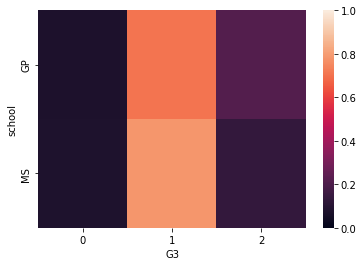

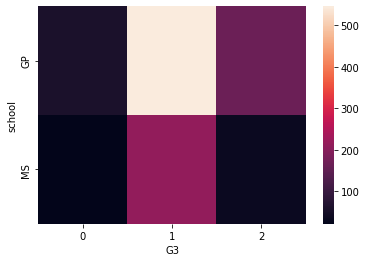

In [ ]:
plt.figure()
xtab(dataset, 'school', 'G3', normalize_on_idx=True)
plt.figure()
xtab(dataset, 'school', 'G3')
"""La scuola GP ha più studenti e più esiti massimi (G3=2) di MS"""

5. Tra i genitori degli studenti considerati, il livello di “educazione” maschile e femminile varia? Sono generalmente più scolarizzati i padri o le madri? Visualizzare poi un grafico che rappresenti il concetto

In [ ]:
print('Mothers education. Mean: {:.2f},'.format(dataset.Medu.mean()), 'Size:',  dataset.Medu.size)
print('Fathers education. Mean: {:.2f},'.format(dataset.Fedu.mean()), 'Size:',  dataset.Fedu.size)

Mothers education. Mean: 2.60, Size: 1044
Fathers education. Mean: 2.39, Size: 1044


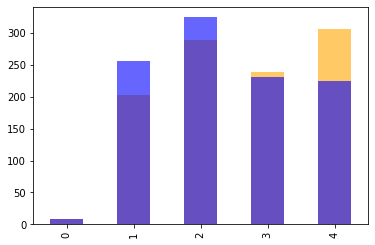

In [ ]:
_ = dataset.Medu.value_counts(sort=False).plot(kind='bar', alpha=0.6, color='orange')
_ = dataset.Fedu.value_counts(sort=False).plot(kind='bar', alpha=0.6, color='blue')

In [ ]:
"""Siccome l'educazione del genitore è codificata con un numero che cresce al
crescere del livello, è possibile fare analisi di tipo numerico.
L'educazione media delle madri è maggiore: infatti, a parità di totale con i
padri, sono presenti più madri laurate (edu=4) e meno con (edu=1) o (edu=2)"""

"Siccome l'educazione del genitore è codificata con un numero che cresce al\ncrescere del livello, è possibile fare analisi di tipo numerico.\nL'educazione media delle madri è maggiore: infatti, a parità di totale con i \npadri, sono presenti più madri laurate (edu=4) e meno con (edu=1) o (edu=2)"

'Conta il numero di istanze per ogni coppia esito-indirizzo, inteso come\nprovenienza rurale o urbana. Ritengo più idonei un grafico a barre o una heatmap'

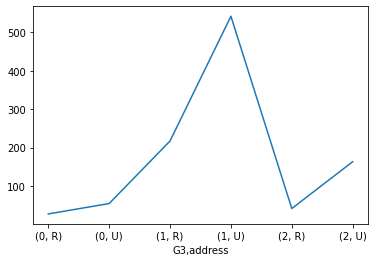

In [ ]:
dataset["G3"].groupby([dataset["G3"], dataset["address"]] ).count().plot()
"""Conta il numero di istanze per ogni coppia esito-indirizzo, inteso come
provenienza rurale o urbana. Ritengo più idonei un grafico a barre o una heatmap"""

# Parte 2: Trasformazione e Predizione

Creare un dataset chiamato “numeric” che contiene solo le features numeriche.
Creare poi un nuovo dataset “reduced” dall’originale con le colonne G1 e G2 e un dataset “lessReduced” togliendo da numeric unicamente le colonne G1 e G2

In [ ]:
numeric_fs = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
              'famrel', 'goout', 'Dalc', 'Walc', 'health', 'absences',
              'G1', 'G2', 'G3']

numeric = dataset[numeric_fs]
reduced = dataset[['G1', 'G2', 'G3']]
lessReduced = numeric.drop(columns=['G1', 'G2'])

2. Si vuole predire G3 sulla base degli altri attributi presenti nel dataset. Dividere i dataset numeric, lessReduced e reduced in modo che 2/3 degli elementi siano contenuti in un nuovo dataset “train” e 1/3 nel dataset “test”.
Valutare l’accuracy ottenuta con il modello LogisticRegression su tutti i dataset (from sklearn.linear_model import LogisticRegression)
Il valore di accuratezza ottenuto è pari a? La confusion matrix presenta qualche valore significativo?

In [ ]:
train, test = train_test_split(numeric, train_size=2/3, random_state=1)
_ = fit_predict_print(train, test, 'G3', LogisticRegression(n_jobs=-1))

Accuracy: 0.9310344827586207
Confusion matrix:
 [[ 16   8   0]
 [  4 251   0]
 [  0  12  57]]


In [ ]:
train, test = train_test_split(reduced, train_size=2/3, random_state=1)
_ = fit_predict_print(train, test, 'G3', LogisticRegression(n_jobs=-1))

Accuracy: 0.9339080459770115
Confusion matrix:
 [[ 16   8   0]
 [  4 251   0]
 [  0  11  58]]


In [ ]:
train, test = train_test_split(lessReduced, train_size=2/3, random_state=1)
_ = fit_predict_print(train, test, 'G3', LogisticRegression(n_jobs=-1))

Accuracy: 0.7413793103448276
Confusion matrix:
 [[  0  24   0]
 [  0 251   4]
 [  0  62   7]]


In [ ]:
"""Le prime due predizioni hanno un'accuratezza molto alta, ma analizzando la
confusion matrix si nota che è dovuta al gran numero di istanze G3=1, predette
quasi tutte correttamente in quasi tutti i casi.
La terza predizione ha un accuratezza inferiore alle altre, e analizzando la
confusion matrix si nota che l'errore è tutto concentrato su G3=0 e G3=2.
Questa discrepanza tra l'ultima predizione e le altre suggerisce la grande
rilevanza di G1 e G2 nella stima di G3."""

"Le prime due predizioni hanno un'accuratezza molto alta, ma analizzando la\nconfusion matrix si nota che è dovuta al gran numero di istanze G3=1, predette\nquasi tutte correttamente in quasi tutti i casi.\nLa terza predizione ha un accuratezza inferiore alle altre, e analizzando la \nconfusion matrix si nota che l'errore è tutto concentrato su G3=0 e G3=2.\nQuesta discrepanza tra l'ultima predizione e le altre suggerisce la grande \nrilevanza di G1 e G2 nella stima di G3."

3. Che valore di accuratezza si ottiene con un 10 Fold cross validation e il modello basato su Decision Tree. E’ più affidabile la valutazione fatta con la cross validation o quella fatta con una suddivisione arbitraria del dataset in due parti, training set e test set? Per quale motivo?

In [ ]:
X = numeric.drop(columns='G3')
y = numeric.G3
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.8370421245421245

In [ ]:
X = reduced.drop(columns='G3')
y = reduced.G3
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.908937728937729

In [ ]:
X = lessReduced.drop(columns='G3')
y = lessReduced.G3
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.6387637362637363

In [ ]:
"""
Cross validation è ritenuto il metodo migliore per allenare un algoritmo
perchè, all'interno di un ciclo, utilizza tutto il dataset sia per il training
che per il testing
"""

"\nCross validation è ritenuto il metodo migliore per allenare un algoritmo\nperchè, all'interno di un ciclo, utilizza tutto il dataset sia per il training\nche per il testing\n"

4. Considerare il dataset numeric. Considerare l’intervallo di valori assunto dall’attributo age e dividerlo in tre parti. Associare a ogni istanza il valore 0,1,2 a seconda del fatto che l’età sia nel primo, nel secondo o nel terzo intervallo. Eliminare l’attributo age originale, non discretizzato e calcolare l’accuratezza con il metodo 10 cross fold validation.

In [ ]:
numeric1 = numeric.copy()

In [ ]:
numeric1.age = pd.cut(dataset.age, bins=3, labels=range(0, 3, 1))

In [ ]:
X = numeric1.drop(columns='G3')
y = numeric1.G3
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.8284615384615386

Trasformare la feature discretizzata in 3 feature booleane, una per ogni valore discretizzato. Il valore assegnato sarà 1 nella colonna che rappresenta il valore in esame. 0 nelle altre colonne. Calcolare l’accuratezza con il metodo 10 cross fold validation

In [ ]:
numeric1.age = pd.cut(dataset.age, bins=3)

In [ ]:
numeric1 = add_dummies(numeric1, 'age')

In [ ]:
numeric1.head()

,Medu,Fedu,traveltime,studytime,failures,famrel,goout,Dalc,Walc,health,absences,G1,G2,G3,"(17.333, 19.667]","(14.993, 17.333]","(19.667, 22.0]"
0,4,4,2,2,0,4,4,1,1,3,6,0,0,0,1.0,0.0,0.0
1,1,1,1,2,0,5,3,1,1,3,4,0,0,0,0.0,1.0,0.0
2,1,1,1,2,3,4,2,2,3,3,10,1,1,1,0.0,1.0,0.0
3,4,2,1,3,0,3,2,1,1,5,2,2,1,2,0.0,1.0,0.0
4,3,3,1,2,0,4,2,1,2,5,4,0,1,1,0.0,1.0,0.0


In [ ]:
X = numeric1.drop(columns='G3')
y = numeric1.G3
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.8389652014652015

5. Aggiungere al dataset “numeric” gli attributi Mjob e Fjob il cui valore categorico deve essere mappato utilizzando una formula di conversione a scelta. Confrontare il risultato ottenuto con quelli ottenuti in precedenza.

In [ ]:
[f'Mjob_{j}' for j in ['j', 'g', 'lll']]

['Mjob_j', 'Mjob_g', 'Mjob_lll']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

mjob_ohe = one_hot_encode(dataset, 'Mjob')
columns = [f'Mjob_{j}' for j in mjob_ohe.columns]

fjob_ohe = one_hot_encode(dataset, 'Fjob')
columns = [f'Fjob_{j}' for j in fjob_ohe.columns]

numeric2 = pd.concat([numeric, mjob_ohe.set_axis(columns, axis=1),
                      fjob_ohe.set_axis(columns, axis=1)], axis=1)

In [ ]:
X = numeric2.drop(columns='G3')
y = numeric2.G3
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.8438095238095238

In [ ]:
numeric2 = pd.concat([numeric, mjob_ohe + fjob_ohe], axis=1)
numeric2.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,goout,Dalc,Walc,health,absences,G1,G2,G3,at_home,health,other,services,teacher
0,18,4,4,2,2,0,4,4,1,1,3,6,0,0,0,1.0,0.0,0.0,0.0,1.0
1,17,1,1,1,2,0,5,3,1,1,3,4,0,0,0,1.0,0.0,1.0,0.0,0.0
2,15,1,1,1,2,3,4,2,2,3,3,10,1,1,1,1.0,0.0,1.0,0.0,0.0
3,15,4,2,1,3,0,3,2,1,1,5,2,2,1,2,0.0,1.0,0.0,1.0,0.0
4,16,3,3,1,2,0,4,2,1,2,5,4,0,1,1,0.0,0.0,2.0,0.0,0.0


In [ ]:
X = numeric2.drop(columns='G3')
y = numeric2.G3
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

0.8552747252747253

In [ ]:
numeric

,age,Medu,Fedu,traveltime,studytime,failures,famrel,goout,Dalc,Walc,health,absences,G1,G2,G3
0,18,4,4,2,2,0,4,4,1,1,3,6,0,0,0
1,17,1,1,1,2,0,5,3,1,1,3,4,0,0,0
2,15,1,1,1,2,3,4,2,2,3,3,10,1,1,1
3,15,4,2,1,3,0,3,2,1,1,5,2,2,1,2
4,16,3,3,1,2,0,4,2,1,2,5,4,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,19,2,3,1,3,1,5,2,1,2,5,4,1,1,1
1040,18,3,1,1,2,0,4,4,1,1,1,4,2,2,2
1041,18,1,1,2,2,0,1,1,1,1,5,6,1,1,1
1042,17,3,1,2,1,0,2,5,3,4,2,6,1,1,1


In [ ]:
numericGP = dataset[dataset.school == 'GP'][numeric_fs]
numericGP.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,goout,Dalc,Walc,health,absences,G1,G2,G3
count,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000
mean,16.601036,2.760363,2.510363,1.410622,2.036269,0.238342,3.955959,3.130829,1.458549,2.264249,3.588083,5.006477,1.116580,1.129534,1.139896
std,1.233513,1.073600,1.089341,0.687891,0.845362,0.644386,0.882532,1.138745,0.880450,1.302543,1.402707,6.849974,0.422315,0.454187,0.523000
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,1.000000,2.000000,4.000000,2.000000,1.000000,1.000000,1.000000
75%,17.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,2.000000,3.000000,5.000000,7.000000,1.000000,1.000000,1.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,2.000000,2.000000,2.000000


In [ ]:
numericMS = dataset[dataset.school == 'MS'][numeric_fs]
numericMS.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,goout,Dalc,Walc,health,absences,G1,G2,G3
count,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,17.080882,2.158088,2.040441,1.841912,1.783088,0.338235,3.878676,3.227941,1.595588,2.341912,3.415441,2.812500,1.022059,1.018382,1.055147
std,1.190709,1.149687,1.056617,0.759205,0.773649,0.684252,1.064344,1.190162,0.989828,1.234800,1.480569,3.369845,0.420278,0.441852,0.463314
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,2.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000
50%,17.000000,2.000000,2.000000,2.000000,2.000000,0.000000,4.000000,3.000000,1.000000,2.000000,4.000000,2.000000,1.000000,1.000000,1.000000
75%,18.000000,3.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,2.000000,3.000000,5.000000,4.000000,1.000000,1.000000,1.000000
max,21.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,17.000000,2.000000,2.000000,2.000000


In [ ]:
trainGP, testGP = train_test_split(numericGP, train_size=2/3, random_state=1)

In [ ]:
trainMS, testMS = train_test_split(numericMS, train_size=2/3, random_state=1)

In [ ]:
test = pd.concat([testGP, testMS])

In [ ]:
_ = fit_predict_print(trainGP, test, 'G3', DecisionTreeClassifier())

Accuracy: 0.8681318681318682
Confusion matrix:
 [[  6   4   0]
 [  6 122  10]
 [  0   4  30]]


In [ ]:
_ = fit_predict_print(trainMS, test, 'G3', DecisionTreeClassifier())

Accuracy: 0.8791208791208791
Confusion matrix:
 [[  6   4   0]
 [  6 124   8]
 [  0   4  30]]


7. Utilizzare un algoritmo di regressione da applicarsi al dataset del punto 1 per predire “G3”. Arrotondare i valori ottenuti all’intero. Confrontare i risultati ottenuti con quelli ottenuti in precedenza

In [ ]:
from sklearn.linear_model import LinearRegression

X = numeric.drop(columns='G3')
y = numeric.G3

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, train_size=2/3, random_state=1)
clf = LinearRegression(n_jobs=-1).fit(X_tr, y_tr)
y_pr = clf.predict(X_ts)

In [ ]:
y_pr = np.around(y_pr)

In [ ]:
metrics.accuracy_score(y_ts, y_pr)

0.9339080459770115

In [ ]:
metrics.confusion_matrix(y_ts, y_pr)

array([[ 16,   8,   0],
       [  4, 251,   0],
       [  0,  11,  58]])